In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csc_matrix
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit,\
                                    cross_val_score, cross_validate, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
from collections import defaultdict
import time
import pickle

In [2]:
SEED = 13
FILL_NA = -1

In [3]:
times = ['time%d' % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]

df_tr = pd.read_csv('train_sessions.csv', parse_dates = times).set_index('session_id').sort_values('time1')
df_te = pd.read_csv('test_sessions.csv', parse_dates = times).set_index('session_id')

In [4]:
def _prepare_data(vectorizer, df_tr, df_te, target_col, holdout_share):
    
    IDX_SPLIT = round(len(df_tr) * (1-holdout_share))
    
    # целевой признак
    target_tr = df_tr[target_col]

    # признаки
    features_tr = df_tr.drop(target_col, 1)
    features_te = df_te

    # сайты, время
    sites_tr, times_tr = features_tr[sites], features_tr[times]
    sites_te, times_te = features_te[sites], features_te[times]

    # оставляем в трейне сайты из теста
    sites_to_use = np.intersect1d(pd.Series(sites_te.values.flatten()).dropna().unique(),\
                                  pd.Series(sites_tr[target_tr==1].values.flatten()).dropna().unique())
    sites_tr = sites_tr.applymap(lambda x: x if x in sites_to_use else FILL_NA)

    # дата начала сессии
    start_tr = times_tr.min(1)
    start_te = times_te.min(1)

    ts_columns = ['dayofyear', 'weekofyear', 'year', 'month',\
                  'day', 'dayofweek', 'hour', 'minute1',\
                  'minute2', 'second1', 'second2']

    times_tr = pd.DataFrame(np.column_stack([start_tr.dt.dayofyear,\
                     start_tr.dt.weekofyear,\
                     start_tr.dt.year,\
                     start_tr.dt.month,\
                     start_tr.dt.day,\
                     start_tr.dt.dayofweek,\
                     start_tr.dt.hour,\
                     start_tr.dt.minute//10,\
                     start_tr.dt.minute%10,\
                     start_tr.dt.second//10,\
                     start_tr.dt.second%10]))
    times_tr.columns = ts_columns

    times_te = pd.DataFrame(np.column_stack([start_te.dt.dayofyear,\
                     start_te.dt.weekofyear,\
                     start_te.dt.year,\
                     start_te.dt.month,\
                     start_te.dt.day,\
                     start_te.dt.dayofweek,\
                     start_te.dt.hour,\
                     start_te.dt.minute//10,\
                     start_te.dt.minute%10,\
                     start_te.dt.second//10,\
                     start_te.dt.second%10]))
    times_te.columns = ts_columns

    # оставляем в трейне значения из теста
    for col in times_tr.columns:
        values_to_use = times_te[col].unique()
        times_tr[col] = times_tr[col].apply(lambda x: x if x in values_to_use else FILL_NA)

    # переведем сайты трейн+тест в строки
    sites_full_str = pd.concat([sites_tr, sites_te], 0)\
        .fillna(FILL_NA).astype(int).astype(str)\
        .apply(lambda x:'_'.join(x), axis = 1)


    # время --> ohe
    ohe_encoder = OneHotEncoder(handle_unknown='ignore')
    ohe_encoder.fit(times_tr)

    times_ohe_tr = ohe_encoder.transform(times_tr)
    times_ohe_te = ohe_encoder.transform(times_te)
    
    tfidf_full = csc_matrix(vectorizer.fit_transform(sites_full_str))
    tfidf_tr, tfidf_te = tfidf_full[:len(df_tr)], tfidf_full[len(df_tr):]

    X_logit_tr = csc_matrix(hstack([times_ohe_tr, tfidf_tr]))
    X_logit_te = csc_matrix(hstack([times_ohe_te, tfidf_te]))    
    
    X_lgb_tr = csc_matrix(hstack([times_tr, tfidf_tr]))
    X_lgb_te = csc_matrix(hstack([times_te, tfidf_te]))   
    
    y_tr = target_tr.values

    X1_TR, X1_HOLD = X_logit_tr[:IDX_SPLIT], X_logit_tr[IDX_SPLIT:]
    X2_TR, X2_HOLD = X_lgb_tr[:IDX_SPLIT], X_lgb_tr[IDX_SPLIT:]
    y_TR, y_HOLD = y_tr[:IDX_SPLIT], y_tr[IDX_SPLIT:]
    
    
    return {'X_logit_TR':X1_TR, 'X_logit_HOLD':X1_HOLD,\
            'X_lgb_TR':X2_TR, 'X_lgb_HOLD':X2_HOLD,\
            'y_TR': y_TR, 'y_HOLD':y_HOLD,\
            'X_logit_te':X_logit_te, 'X_lgb_te':X_lgb_te}

In [5]:
logit_clf= LogisticRegression(random_state = SEED)
lgb_clf = LGBMClassifier(random_state = SEED)

In [6]:
L_NGRAM_RANGE = [(1, 1), (1, 2), (1, 3)]
L_MAX_FEATURES = [10, 100]
L_NFOLDS = np.arange(3, 13)
EARLY_STOPPING = 100

In [1]:
start = time.time()

cvAB = []
for NGRAM_RANGE in tqdm_notebook(L_NGRAM_RANGE):
    for MAX_FEATURES in tqdm_notebook(L_MAX_FEATURES):
        
        D_datasets = _prepare_data(vectorizer = TfidfVectorizer(ngram_range = NGRAM_RANGE, max_features = MAX_FEATURES),\
                                   df_tr=df_tr, df_te=df_te,\
                                   target_col='target',\
                                   holdout_share=.1)
                
        # получаем auc на отложенной для логита, бустинга
        logit_clf.fit(D_datasets['X_logit_TR'], D_datasets['y_TR'])
        y_PREDPROB = logit_clf.predict_proba(D_datasets['X_logit_HOLD'])[:, 1]
        logit_hold = roc_auc_score(D_datasets['y_HOLD'], y_PREDPROB)
        
        lgb_clf.fit(D_datasets['X_lgb_TR'], D_datasets['y_TR'])
        y_PREDPROB = lgb_clf.predict_proba(D_datasets['X_lgb_HOLD'])[:, 1]
        lgb_hold = roc_auc_score(D_datasets['y_HOLD'], y_PREDPROB)
        
        # валидации
        for nfolds in tqdm_notebook(L_NFOLDS):
            # фиксируем число фолдов
            TSCV = TimeSeriesSplit(nfolds)
            # валидация лоигта без тюна
            cv_logit = cross_validate(logit_clf, D_datasets['X_logit_TR'], D_datasets['y_TR'],\
                                      cv = TSCV, scoring = 'roc_auc')['test_score'].mean()
            # валидация лгб без тюна
            cv_lgb = cross_validate(lgb_clf, D_datasets['X_lgb_TR'], D_datasets['y_TR'],\
                                    cv = TSCV, scoring = 'roc_auc')['test_score'].mean()
            # коллекцнионируем валидацию, оптимальные гиперпараметры
            cvAB.append((NGRAM_RANGE, MAX_FEATURES, nfolds, cv_logit, cv_lgb, logit_hold, lgb_hold))    

cv_AB = pd.DataFrame.from_records(cvAB)
cv_AB.columns = ['ngram_range', 'max_features', 'nfolds', 'cv_logit', 'cv_lgb', 'hold_logit', 'hold_lgb']

end = time.time()
duration = (end-start)//60
print('выполнено за {} часов, {} минут'.format(duration//60, duration%60))

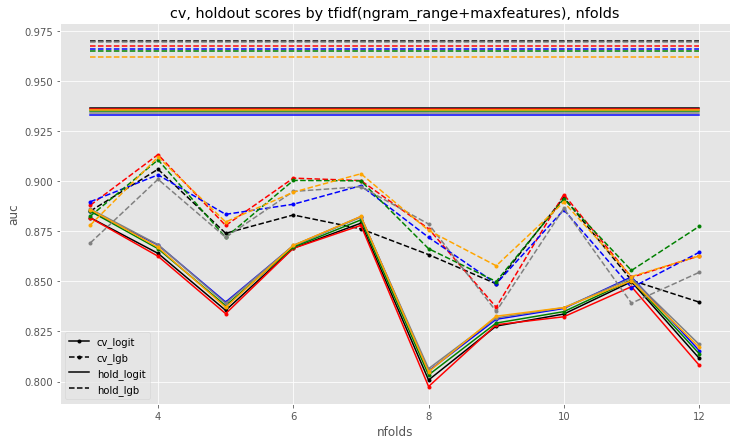

In [10]:
grouped = cv_AB.groupby(['ngram_range', 'max_features'])
ngroups = len(grouped)
colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']

plt.figure(figsize = (12, 7))
for ((_ngram_range, _maxfeatures), subdf), color in zip(grouped, colors):
    _subdf = subdf.sort_values('nfolds').set_index('nfolds')
    _subdf['cv_logit'].plot(color = color, marker = '.')
    _subdf['cv_lgb'].plot(color = color, linestyle = '--', marker = '.')
    _subdf['hold_logit'].plot(color = color)
    _subdf['hold_lgb'].plot(color = color, linestyle = '--')
    
plt.legend(['cv_logit', 'cv_lgb', 'hold_logit', 'hold_lgb'])
plt.xlabel('nfolds')
plt.ylabel('auc')
plt.title('cv, holdout scores by tfidf(ngram_range+maxfeatures), nfolds')
plt.show()    

In [7]:
class FeatureSelector():
    def __init__(self, estimator,
                       metric,\
                       larger_is_better,\
                       cv,
                       use_values,\
                       use_recursion,
                       fill_na,\
                       show_progress, 
                       early_stopping = None):
        '''
        Инициализирует модель для отбора признаков
        
        Параметры:
            1) estimator - модель
            2) metric - метрика качества (названия метрик sklearn + может быть кастомная)
            3) larger_is_better - критерий оптимизации (чем больше, тем лучше)
            4) cv - схема валидации
            5) use_values - индексы столбцов, в которых требуется отобрать значения
            6) use_recursion - использовать рекурсию в отборе
            7) fill_na - значение, которым заполняются np.nan
            8) show_progress - печатать результаты валидации
            9) early_stopping - число итераций без улучшения метрики для ранней остановки отбора
        Возвращает:
            1) fit - производит отбор признаков
            2) transform - оставляет отобранные признаки
            3) return_self - возвращает 
                - best_features - отобранные признаки(список)
                - D_best_features - отобранные значения признаков (словарь: {признак:значения})
                - best_score - лучшее значение метрики
        '''
        self.estimator = estimator
        self.metric = metric
        self.cv = cv
        self.use_values = use_values        
        self.use_recursion = use_recursion
        self.show_progress = show_progress
        self.early_stopping = early_stopping
        self.fill_na = fill_na
        self.larger_is_better = larger_is_better
    def fit(self, X, Y):        
        flag = isinstance(X[:, 0], csc_matrix)
        # список с результатами валидации
        column_value_score = []
        # проходим по признакам
        for i in tqdm_notebook(range(X.shape[1])):
            # если формат матрицы признаков == csc_matrix
            if flag:
                # выбираем столбец, преобразуем
                ser = pd.DataFrame(X[:, i].todense())[0].values.flatten()
            # если формат != csc_matrix
            else:
                # выбираем столбец
                ser = X[:, i]        
            # если столбец в списке с проверкой значений 
            if self.use_values is not None:                
                if i in self.use_values:
                    # уникальные значения столбца
                    unique_values = np.unique(ser)  
                    # валидируем каждое значение
                    for val in unique_values:
                        _x = np.int32(ser==val).reshape(-1,1)
                        column_value_score.append((i, val,\
                                                   cross_val_score(self.estimator,\
                                                                   _x, Y,\
                                                                   scoring = self.metric,\
                                                                   cv = self.cv).mean()))
                else: 
                    # валидируем столбец
                    column_value_score.append((i, None,\
                                               cross_val_score(self.estimator,\
                                                               _x, Y,\
                                                               scoring = self.metric,\
                                                               cv = self.cv).mean()))
            else:
                # валидируем столбец
                    column_value_score.append((i, None,\
                                               cross_val_score(self.estimator,\
                                                               ser.reshape(-1,1), Y,\
                                                               scoring = self.metric,\
                                                               cv = self.cv).mean()))
                

        # признаки и значения признаков в порядке убывания валидации
        order = np.array(sorted(column_value_score, key = lambda x: x[-1], reverse = True))[:, :2]             
        # список лучших признаков
        best_features = []
        # словарь лучших значений признаков
        D_best_features = defaultdict(list)
        # список с признаками, не давшими прироста
        to_drop = []
        
        # лучшее значение метрики
        if self.larger_is_better:
            best_score = 0
        else:
            best_score = np.inf            
        counter = 0
        # проходим по признакам и значениям признаков в порядке убывания валидации
        for feature, feature_value in tqdm_notebook(order):   

            # добавляем текущие признаки/значения
            if feature_value is None:
                best_features.append(feature)               
            else:
                D_best_features[feature].append(feature_value)

            # обновляем матрицы
            L = []
            for k, v in D_best_features.items():
                if isinstance(X[:, k], csc_matrix):
                    L.append(pd.DataFrame(X[:, k].tocsc().todense())[0].apply(lambda x: x if x in v else self.fill_na))
                else:
                    L.append(pd.Series(X[:, k].flatten()).apply(lambda x: x if x in v else self.fill_na))

            if flag:
                if (len(best_features)>0) & (len(L)>0):
                    _X = csc_matrix(hstack([X[:, best_features], csc_matrix(np.column_stack(L)) ]))
                elif (len(best_features)==0) & (len(L)>0):
                    _X = csc_matrix(np.column_stack(L))
                elif (len(best_features)>0) & (len(L)==0):
                    _X = csc_matrix(X[:, best_features])                    
                        
            else:
                if (len(best_features)>0) & (len(L)>0):
                    _X = np.column_stack([X[:, best_features], np.column_stack(L)])
                elif (len(best_features)==0) & (len(L)>0):
                    _X = np.column_stack(L)
                elif (len(best_features)>0) & (len(L)==0):
                    _X = X[:, best_features] 
            # считаем валидацию    
            current_score = cross_val_score(self.estimator, _X, Y, scoring = self.metric, cv = self.cv).mean()
            # если метрика улучшилась
            if self.larger_is_better:
                if current_score>best_score:
                    # обновляем лучшую метрику
                    best_score = current_score
                    counter = 0
                    # печатаем 
                    if self.show_progress:
                        print('new best_score = {}'.format(best_score))
                # если метрика не улучшилась
                else: 
                    counter+=1
                    # удаляем признак/значение
                    if feature_value is None:
                        best_features = [val for val in best_features if val != feature]
                        to_drop.append((feature, None))
                    else:
                        D_best_features[feature] = [val for val in D_best_features[feature] if val != feature_value]    
                        to_drop.append((feature, feature_value))
                    if counter == self.early_stopping:
                        break
            else:
                if current_score<best_score:
                    # обновляем лучшую метрику
                    best_score = current_score
                    counter = 0
                    # печатаем 
                    if self.show_progress:
                        print('new best_score = {}'.format(best_score))
                    # если метрика не улучшилась
                else: 
                    counter+=1
                    # удаляем признак/значение
                    if feature_value is None:
                        best_features = [val for val in best_features if val != feature]
                        to_drop.append((feature, None))
                    else:
                        D_best_features[feature] = [val for val in D_best_features[feature] if val != feature_value]    
                        to_drop.append((feature, feature_value))
                    if counter == self.early_stopping:
                        break

        if self.use_recursion:
            # запускаем бесконечный цикл
            while True:
                # списки лучших признаков до и после
                to_drop_before = to_drop
                to_drop_after = []
                # проходим по признакам и значениям признаков в порядке убывания валидации
                for feature, feature_value in tqdm_notebook(to_drop_before):   
                    # добавляем текущие признаки/значения
                    if feature_value is None:
                        best_features.append(feature)               
                    else:
                        D_best_features[feature].append(feature_value)

                    # обновляем матрицы
                    L = []
                    for k, v in D_best_features.items():
                        if isinstance(X[:, k], csc_matrix):
                            L.append(pd.DataFrame(X[:, k].tocsc().todense())[0].apply(lambda x: x if x in v else self.fill_na))
                        else:
                            L.append(pd.Series(X[:, k].flatten()).apply(lambda x: x if x in v else self.fill_na))

                    if flag:
                        if (len(best_features)>0) & (len(L)>0):
                            _X = csc_matrix(hstack([X[:, best_features], csc_matrix(np.column_stack(L)) ]))
                        elif (len(best_features)==0) & (len(L)>0):
                            _X = csc_matrix(np.column_stack(L))
                        elif (len(best_features)>0) & (len(L)==0):
                            _X = csc_matrix(X[:, best_features])                    

                    else:
                        if (len(best_features)>0) & (len(L)>0):
                            _X = np.column_stack([X[:, best_features], np.column_stack(L)])
                        elif (len(best_features)==0) & (len(L)>0):
                            _X = np.column_stack(L)
                        elif (len(best_features)>0) & (len(L)==0):
                            _X = X[:, best_features] 

                    # считаем валидацию    
                    current_score = cross_val_score(self.estimator, _X, Y, scoring = self.metric, cv = self.cv).mean()
                    
                    
                    
                    
                    
                    
                    if self.larger_is_better:
                        if current_score>best_score:
                            # обновляем лучшую метрику
                            best_score = current_score
                            counter = 0
                            # печатаем 
                            if self.show_progress:
                                print('new best_score = {}'.format(best_score))
                            # если метрика не улучшилась
                        else: 
                            # удаляем признак/значение
                            if feature_value is None:
                                best_features = [val for val in best_features if val != feature]
                                to_drop_after.append((feature, None))
                            else:
                                D_best_features[feature] = [val for val in D_best_features[feature] if val != feature_value]    
                                to_drop_after.append((feature, feature_value))
                    else:
                        if current_score<best_score:
                            # обновляем лучшую метрику
                            best_score = current_score
                            counter = 0
                            # печатаем 
                            if self.show_progress:
                                print('new best_score = {}'.format(best_score))
                        else: 
                            # удаляем признак/значение
                            if feature_value is None:
                                best_features = [val for val in best_features if val != feature]
                                to_drop_after.append((feature, None))
                            else:
                                D_best_features[feature] = [val for val in D_best_features[feature] if val != feature_value]    
                                to_drop_after.append((feature, feature_value))
                    

                # если списки одинаковые, останавливаем отбор
                if len(to_drop_after) == len(to_drop_before):
                    break
                # если разные - обновляем списки до и после
                else:
                    to_drop_before = to_drop_after
                    to_drop_after = []
                    
        self.best_features = best_features
        self.D_best_features = D_best_features
        self.best_score =best_score
        self.flag = flag
    def transform(self, X):
              
        if len(self.best_features) !=0:
            x1 = X[:, self.best_features]
        else:
            x1 = None
        if len(list(self.D_best_features.keys())) !=0:
            L=[]
            for k, v in self.D_best_features.items():
                if self.flag:
                    L.append(pd.DataFrame(X[:, k].tocsc().todense())[0].apply(lambda x: x if x in v else self.fill_na))                    
                else:
                    L.append(pd.Series(X[:, k].flatten()).apply(lambda x: x if x in v else self.fill_na))
            x2 = np.column_stack(L)
        else:
            x2 = None
            
        if (x1 is not None) & (x2 is not None):
            if self.flag: 
                _X = csc_matrix(hstack([x1, x2]))
            else:
                _X = np.column_stack([x1, x2])
                
        if (x1 is not None) & (x2 is None):
            _X = x1
        if (x1 is None) & (x2 is not None):
            if self.flag:
                _X = csc_matrix(x2)
            else:
                _X = x2
        return _X     
        
    def return_self(self):
        return self

In [2]:
start = time.time()

logit_selected_TR_L, logit_selected_HOLD_L, logit_selected_te_L = [], [], []
lgb_selected_TR_L, lgb_selected_HOLD_L, lgb_selected_te_L = [], [], []

for NGRAM_RANGE in tqdm_notebook(L_NGRAM_RANGE):
    for MAX_FEATURES in tqdm_notebook(L_MAX_FEATURES):
        D_datasets = _prepare_data(vectorizer = TfidfVectorizer(ngram_range = NGRAM_RANGE, max_features = MAX_FEATURES),\
                                    df_tr=df_tr, df_te=df_te,\
                                    target_col='target',\
                                    holdout_share=.1)
        # валидации
        for nfolds in tqdm_notebook(L_NFOLDS):
            # фиксируем число фолдов
            TSCV = TimeSeriesSplit(nfolds)

            logit_selector = FeatureSelector(estimator = logit_clf,\
                                                    metric = 'roc_auc',\
                                                    larger_is_better = True,\
                                                    cv = TSCV,\
                                                    use_values = None,\
                                                    use_recursion = False,\
                                                    fill_na = FILL_NA,\
                                                    show_progress = False, 
                                                    early_stopping = None)

            logit_selector.fit(D_datasets['X_logit_TR'], D_datasets['y_TR'])
            logit_selected_TR_L.append(logit_selector.transform(D_datasets['X_logit_TR']))
            logit_selected_HOLD_L.append(logit_selector.transform(D_datasets['X_logit_HOLD']))
            logit_selected_te_L.append(logit_selector.transform(D_datasets['X_logit_te']))

            lgb_selector = FeatureSelector(estimator = lgb_clf,\
                                                    metric = 'roc_auc',\
                                                    larger_is_better = True,\
                                                    cv = TSCV,\
                                                    use_values = np.arange(0, 11).tolist(),\
                                                    use_recursion = False,\
                                                    fill_na = FILL_NA,\
                                                    show_progress = False, 
                                                    early_stopping = None)

            lgb_selector.fit(D_datasets['X_lgb_TR'], D_datasets['y_TR'])
            lgb_selected_TR_L.append(lgb_selector.transform(D_datasets['X_lgb_TR']))
            lgb_selected_HOLD_L.append(lgb_selector.transform(D_datasets['X_lgb_HOLD']))
            lgb_selected_te_L.append(lgb_selector.transform(D_datasets['X_lgb_te']))
            
end = time.time()
duration = (end-start)//60
print('выполнено за {} часов, {} минут'.format(duration//60, duration%60))

In [20]:
auc_holdout_L = []
for nfolds, x_logit_tr, x_logit_hold, x_lgb_tr, x_lgb_hold in tqdm_notebook(zip(L_NFOLDS,\
                                                                                logit_selected_TR_L, logit_selected_HOLD_L,\
                                                                                lgb_selected_TR_L, lgb_selected_HOLD_L),\
                                                                            total = len(L_NFOLDS)):
    logit_clf.fit(x_logit_tr, D_datasets['y_TR'])
    auc_logit_hold = roc_auc_score(D_datasets['y_HOLD'], logit_clf.predict_proba(x_logit_hold)[:, 1])
    
    lgb_clf.fit(x_lgb_tr, D_datasets['y_TR'])
    auc_lgb_hold = roc_auc_score(D_datasets['y_HOLD'], lgb_clf.predict_proba(x_lgb_hold)[:, 1])
    
    auc_holdout_L.append((nfolds, auc_logit_hold, auc_lgb_hold))

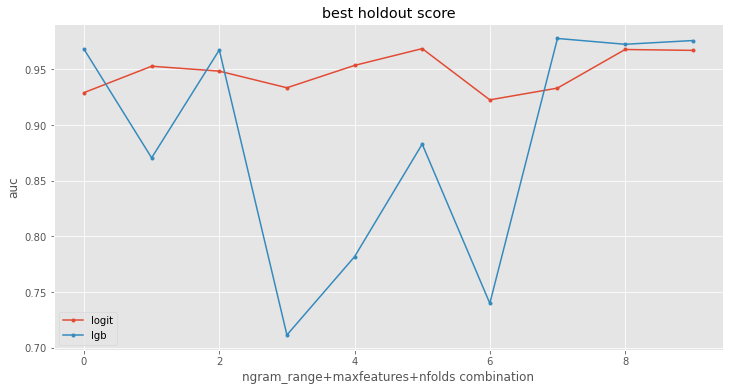

In [32]:
df_report_holdout = pd.DataFrame.from_records(auc_holdout_L)\
                      .rename(columns = {0:'nfolds', 1:'logit', 2:'lgb'})\
                      .drop('nfolds', 1)

df_report_holdout.plot(marker = '.', figsize = (12, 6))
plt.xlabel('ngram_range+maxfeatures+nfolds combination')
plt.ylabel('auc')
plt.title('best holdout score')
plt.show()

In [36]:
df_report_holdout.sort_values('logit', ascending = False).head()

,logit,lgb
5,0.968755,0.882933
8,0.967968,0.972651
9,0.967172,0.976006
4,0.953666,0.781769
1,0.952940,0.870592


* логит модели 5, 8, 9 показали сравнимые результаты 
* число отобранных признаков: 24, 20, 21 соответственно

In [45]:
print('число признаков = {}, {}, {}'\
      .format(logit_selected_TR_L[5].shape[1],\
              logit_selected_TR_L[8].shape[1],\
              logit_selected_TR_L[9].shape[1]))

число признаков = 24, 20, 21


In [61]:
df_report_holdout.sort_values('lgb', ascending = False)

,logit,lgb
7,0.933269,0.977878
9,0.967172,0.976006
8,0.967968,0.972651
0,0.929209,0.968236
2,0.948516,0.967558
5,0.968755,0.882933
1,0.952940,0.870592
4,0.953666,0.781769
6,0.922709,0.739851
3,0.933576,0.711413


In [63]:
logit_features_TR, logit_features_HOLD, logit_features_te = [], [], []
for i in [5, 8, 9]:
    logit_features_TR.append(logit_selected_TR_L[i])
    logit_features_HOLD.append(logit_selected_HOLD_L[i])
    logit_features_te.append(logit_selected_te_L[i])
    
lgb_features_TR, lgb_features_HOLD, lgb_features_te = [], [], []
for i in [2, 0, 8, 9, 7]:
    lgb_features_TR.append(lgb_selected_TR_L[i])
    lgb_features_HOLD.append(lgb_selected_HOLD_L[i])
    lgb_features_te.append(lgb_selected_te_L[i])

In [8]:
# сохраняем признаки
# with open('logit_features_TR.pickle', 'wb') as f:
#     pickle.dump(logit_features_TR, f)
# with open('logit_features_HOLD.pickle', 'wb') as f:
#     pickle.dump(logit_features_HOLD, f)
# with open('logit_features_te.pickle', 'wb') as f:
#     pickle.dump(logit_features_te, f)
    
# with open('lgb_features_TR.pickle', 'wb') as f:
#     pickle.dump(lgb_features_TR, f)
# with open('lgb_features_HOLD.pickle', 'wb') as f:
#     pickle.dump(lgb_features_HOLD, f)
# with open('lgb_features_te.pickle', 'wb') as f:
#     pickle.dump(lgb_features_te, f)

# загружаем признаки
with open('logit_features_TR.pickle', 'rb') as f:
    logit_features_TR = pickle.load(f)
with open('logit_features_HOLD.pickle', 'rb') as f:
    logit_features_HOLD = pickle.load(f)
with open('logit_features_te.pickle', 'rb') as f:
    logit_features_te = pickle.load(f)
    
with open('lgb_features_TR.pickle', 'rb') as f:
    lgb_features_TR = pickle.load(f)
with open('lgb_features_HOLD.pickle', 'rb') as f:
    lgb_features_HOLD = pickle.load(f)
with open('lgb_features_te.pickle', 'rb') as f:
    lgb_features_te = pickle.load(f)

In [9]:
class StackingEstimator():
    def __init__(self, models, cv):
        '''
        models - список с ансамблем моделей
        cv - схема валидации
        '''        
        self.models = models
        self.cv = cv        
    def fit(self, X, y):
        '''
        1) обучаем модели на валидации
        2) сохраняем обученные модели
        '''        
               
        estimators = []
        for model in self.models:  
            try:                
                for tr_idx, val_idx in self.cv.split(y):
                    model.fit(X[tr_idx], y[tr_idx])
                    estimators.append(model)
            except:
                for tr_idx, val_idx in self.cv.split(X, y):
                    model.fit(X[tr_idx], y[tr_idx])
                    estimators.append(model)                
        self.fitted_estimators = estimators
    def transform(self, X):
        '''
        с помощью обученных моделей получаем метапризнаки
        '''
        L = []    
        for estimator in self.fitted_estimators:
            try:
                L.append(estimator.predict_proba(X)[:, 1])
            except:
                L.append(estimator.predict(X))                
        return np.column_stack(L)

In [10]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# базовые модели
BASE_MODELS_LINEAR = [Lasso(random_state = SEED),\
                      Ridge(random_state = SEED)]
#                       KNeighborsRegressor(),\
#                       RadiusNeighborsRegressor(),
#                       LinearSVR(random_state = SEED)]

BASE_MODELS_TREE = [#RandomForestRegressor(random_state = SEED),\
                    LGBMRegressor(random_state = SEED),\
                    XGBRegressor(random_state = SEED),\
                    #KNeighborsRegressor(),\
                    DecisionTreeRegressor(random_state = SEED)]

N_STACK_ITERATIONS = 10
L_SUBSAMPLE = [.5, .7, .9]

metafeatures_TR, metafeatures_HOLD, metafeatures_te = [], [], []

In [3]:
# используем признаки, отобранные для логрегрессии, бустинга
for model_type_names, features in tqdm_notebook(zip(('linear', 'tree'),
                                                    (
                                                     (logit_features_TR, logit_features_HOLD, logit_features_te),
                                                     (lgb_features_TR, lgb_features_HOLD, lgb_features_te)
                                                    )
                                                   ),\
                                                total = 2):
    
    # трейн, отложенная, тест
    _features_TR, _features_HOLD, _features_te = features

    # производим стекинг N_STACK_ITERATIONS раз
    for iteration in tqdm_notebook(range(N_STACK_ITERATIONS)):    

        # доля признаков, участвующих в обучении моделей
        for idx_subsample, subsample_share in tqdm_notebook(enumerate(L_SUBSAMPLE), total = len(L_SUBSAMPLE)):

            # отобранные признаки
            for feat_TR, feat_HOLD, feat_te in tqdm_notebook(zip(_features_TR, _features_HOLD, _features_te),\
                                                             total = len(features)):

                # фиксируем сид
                np.random.RandomState(SEED+iteration+1+idx_subsample+1)

                # выбираем признаки
                nfeatures = feat_TR.shape[1]
                n_to_select = np.int32(np.around(subsample_share*nfeatures))
                selected_feat_idxs = np.random.choice(np.arange(nfeatures), n_to_select)            

                # используем разные валидационные схемы для получения метапризнаков
                for nfolds in tqdm_notebook(L_NFOLDS):

                    # валидация
                    tscv = TimeSeriesSplit(nfolds)

                    # фитим стекинг
                    if model_type_names == 'linear':
                        stack = StackingEstimator(models = BASE_MODELS_LINEAR, cv = tscv)                        
                    else:
                        stack = StackingEstimator(models = BASE_MODELS_TREE, cv = tscv)  
                        
                    stack.fit(feat_TR[:, selected_feat_idxs], D_datasets['y_TR'])

                    # получаем метапризнаки
                    metafeatures_TR.append(stack.transform(feat_TR[:, selected_feat_idxs]))
                    metafeatures_HOLD.append(stack.transform(feat_HOLD[:, selected_feat_idxs]))
                    metafeatures_te.append(stack.transform(feat_te[:, selected_feat_idxs]))

In [ ]:
# финальные признаки трейн, отложенная, тест
X_meta_TR, X_meta_HOLD, X_meta_te = np.column_stack(metafeatures_TR),\
                                    np.column_stack(metafeatures_HOLD),\
                                    np.column_stack(metafeatures_te)

In [ ]:
# в качестве финальных моделей используем логрегрессию, бустинг
FINAL_ESTIMATORS = [logit_clf, lgb_clf]
# число признаков
TOTAL_FEATURES = X_meta_TR.shape[1]

In [ ]:
# отобранные метапризнаки
L_selected = []

for name, estimator in zip(('logit', 'lgb'), FINAL_ESTIMATORS):
    
    # auc каждого признака 
    aucs = []
    for i in range(TOTAL_FEATURES):
        estimator.fit(X_meta_TR[:, i].reshape(-1, 1), D_datasets['y_TR'])
        y_predprob = estimator.predict_proba(X_meta_HOLD[:, i].reshape(-1, 1))[:, 1]
        aucs.append(roc_auc_score(D_datasets['y_HOLD'], y_predprob))
    
    # индексы в порядке уменьшения auc
    order = np.argsort(aucs)[::-1]
    
    # лучшие признаки, лучший скор, признаки на удаление
    best_features = []
    best_score = .5
    to_drop = []
    
    # последовательно добавляем признаки при увеличении метрики
    # выбрасываем при отсутствии увеличения
    for i in tqdm_notebook(order):
        current_features = best_features + [i]
        
        estimator.fit(X_meta_TR[:, current_features], D_datasets['y_TR'])
        y_predprob = estimator.predict_proba(X_meta_HOLD[:, current_features])[:, 1]
        current_score = roc_auc_score(D_datasets['y_HOLD'], y_predprob)
        
        if current_score>best_score:
            best_score = current_score
            best_features = current_features
        else:
            to_drop.append(i)
            
    to_drop_before = to_drop
    to_drop_after = []
    
    # рекурсивно отбираем признаки из выброшенных
    while True:
        for i in tqdm_notebook(to_drop_before):
            current_features = best_features + [i]
        
            estimator.fit(X_meta_TR[:, current_features], D_datasets['y_TR'])
            y_predprob = estimator.predict_proba(X_meta_HOLD[:, current_features])[:, 1]
            current_score = roc_auc_score(D_datasets['y_HOLD'], y_predprob)

            if current_score>best_score:
                best_score = current_score
                best_features = current_features
            else:
                to_drop_after.append(i)
                
        if len(to_drop_before) == len(to_drop_after):
            break
        else:
            to_drop_before = to_drop_after
            to_drop_after = []
            
    L_selected.append((name, best_score, best_features))    

In [ ]:
X_logit_selected_TR = X_meta_TR[:, L_selected[0][-1]]
X_lgb_selected_TR = X_meta_TR[:, L_selected[1][-1]]

X_logit_selected_HOLD = X_meta_HOLD[:, L_selected[0][-1]]
X_lgb_selected_HOLD = X_meta_HOLD[:, L_selected[1][-1]]

X_logit_selected_te = X_meta_te[:, L_selected[0][-1]]
X_lgb_selected_te = X_meta_te[:, L_selected[1][-1]]

In [ ]:
X_logit_selected_tr = np.row_stack([X_logit_selected_TR, X_logit_selected_HOLD])
X_lgb_selected_tr = np.row_stack([X_lgb_selected_TR, X_lgb_selected_HOLD])
y_tr = np.row_stack([D_datasets['y_TR'].reshape(-1, 1), D_datasets['y_HOLD'].reshape(-1, 1)])

In [ ]:
logit_clf.fit(X_logit_selected_tr, y_tr)
lgb_clf.fit(X_lgb_selected_tr, y_tr)

In [ ]:
w1 = .4
w2 = 1-w1

final_blend = logit_clf.predict_proba(X_logit_selected_te)[:, 1]*w1+\
              lgb_clf.predict_proba(X_lgb_selected_te)[:, 1]*w2